# DESCRIPTION

As solvent input - its nD, alpha, beta, gamma, epsilon, phi, psi
As solute input - its classes - levels 1, 2, 3
Linear network:
    Linear(10, 512)
    ReLU
    Linear(512, 128)
    ReLU
    Linear(128, 10)
    ReLU
    Linear(10, 1)

# Importing

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from

# Deleting charges species

In [2]:
filename = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSol-v2009_energies_v2.tsv'
with open(filename) as f:
    t=0
    data = pd.read_table(f)
    df1 = pd.DataFrame(data)

df2 = df1.loc[df1['Charge'].isin([0])]

In [3]:
df2.head(6)

,No.,FileHandle,SoluteName,Charge,Level1,Level2,Level3,Solvent,DeltaGsolv,type,...,S,HS,SS,P,OP,SP,Si,OSi,OS,TotalArea
0,1,0400hyd,hydrogen,0,1,1,0,water,2.33,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
1,2,0400hyd,hydrogen,0,1,1,0,hexadecane,1.64,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
2,3,0400hyd,hydrogen,0,1,1,0,octanol,1.76,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.747
3,4,0216amm,ammonia,0,1,2,0,water,-4.29,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789
4,5,0216amm,ammonia,0,1,2,0,hexadecane,-0.93,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789
5,6,0216amm,ammonia,0,1,2,0,benzene,-1.12,abs,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.789


In [4]:
df2['Solvent'].value_counts()

water                  345
octanol                206
hexadecane             190
chloroform             105
cyclohexane             91
                      ... 
butanol-water            1
dibutylether-water       1
chlorobenzene-water      1
dibromoethane-water      1
nitrobenzene-water       1
Name: Solvent, Length: 106, dtype: int64

In [5]:
df2['SoluteName'].value_counts()

ethanol                                                                                      65
toluene                                                                                      60
2-butanone                                                                                   60
n-octane                                                                                     53
nitromethane                                                                                 52
                                                                                             ..
butenyne                                                                                      1
fluoroacetamide                                                                               1
benzylalcohol                                                                                 1
azetidine                                                                                     1
(2-dimethylamino-5,6-dimethyl-pyrimidin-

# Deleting solvent mixtures

In [6]:
filename2 = r'/Users/balepka/Yandex.Disk.localized/Study/Lab/Neural Network/MNSolDatabase_v2012/Solvent_properties.tsv'
with open(filename2) as f:
    data = pd.read_table(f, header=1)
    solvent_props = pd.DataFrame(data)

In [7]:
names = []
for name, count in df2['Solvent'].value_counts().items():
    row = solvent_props.loc[solvent_props['Name'] == name]
    values = np.array(row[['nD', 'alpha', 'beta', 'gamma', 'epsilon', 'phi', 'psi']])
    # print(f'{name} -> {count} -> {values.shape[0]}')
    if values.shape[0] == 0:
        print(name)
        names.append(name)
df3 = df2.loc[~df2['Solvent'].isin(names)]



octanol-water
diethylether-water
chloroform-water
heptane-water
isopropyltoluene
cyclohexane-water
benzene-water
ethylacetate-water
dichloroethane-water
carbontet-water
hexane-water
butanol-water
dibutylether-water
chlorobenzene-water
dibromoethane-water
nitrobenzene-water


CREATING X and y

In [8]:
X1 = torch.from_numpy(df3.iloc[:, 4:7].values).float()
X2 = df3['Solvent'].values
X3 = pd.DataFrame()
for s in X2:
    # print(s)
    # print(solvent_props.loc[solvent_props['Name'] == s])
    X3 = X3.append(solvent_props.loc[solvent_props['Name'] == s])
X4 = torch.from_numpy(X3.iloc[:, 2:9].values).float()
X = torch.hstack((X1, X4))
y = torch.from_numpy(df3['DeltaGsolv'].values).float()

In [9]:
X.shape

torch.Size([2411, 10])

# Define 1D ResNet network

In [10]:
"""
resnet for 1-d signal data, pytorch version

Shenda Hong, Oct 2019
"""

import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
# from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, index):
        return (torch.tensor(self.data[index], dtype=torch.float), torch.tensor(self.label[index], dtype=torch.long))

    def __len__(self):
        return len(self.data)

class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=self.kernel_size,
            stride=self.stride,
            groups=self.groups)

    def forward(self, x):

        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.conv(net)

        return net

class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):

        net = x

        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)

        net = self.max_pool(net)

        return net

class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            groups=self.groups)

        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):

        identity = x

        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)

        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)

        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)

        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)

        # shortcut
        out += identity

        return out

class ResNet1D(nn.Module):
    """

    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)

    Output:
        out: (n_samples)

    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes

    """

    def __init__(self, in_channels, base_filters, kernel_size, stride, groups, n_block, n_classes, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()

        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters

        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels

            tmp_block = BasicBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=self.kernel_size,
                stride = self.stride,
                groups = self.groups,
                downsample=downsample,
                use_bn = self.use_bn,
                use_do = self.use_do,
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        out = x

        # first conv
        if self.verbose:
            print('input shape', out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print('after first conv', out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)

        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print('i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}'.format(i_block, net.in_channels, net.out_channels, net.downsample))
            out = net(out)
            if self.verbose:
                print(out.shape)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print('final pooling', out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print('dense', out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print('softmax', out.shape)

        return out

In [11]:
class FCNet(nn.Module):
    def __init__(self, x_len = 10):
        self.x_len = x_len
        super().__init__()
        self.fc1 = nn.Linear(self.x_len, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):  # Forward will be Called from  parent __call__ method
        x = x.view(-1, self.x_len)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [12]:
np.random.seed(42)
ids = np.random.permutation(X.shape[0])
val_start = int(X.shape[0] * 0.8)
test_start = int(X.shape[0] * 0.9)

train_ids = ids[:val_start]
val_ids = ids[val_start:test_start]
test_ids = ids[test_start:]


X_train, X_val, X_test, y_train, y_val, y_test = X[train_ids], X[val_ids], X[test_ids], y[train_ids], y[val_ids], y[test_ids]

In [13]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [31]:
X_train1 = torch.reshape(X_train, (1928, 1, 10))

X_val1 = torch.reshape(X_val, (241, 1, 10))

X_val1.shape


torch.Size([241, 1, 10])

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet1D(1, 2, 3, 1, 1, 3, 1).to(device)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 2, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0): BasicBlock(
      (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(2, 2, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): BasicBlock(
      (bn1): BatchNorm1d(2,

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCNet().to(device)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

FCNet(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


In [21]:
type(X_train)

torch.Tensor

In [34]:
from tqdm import tqdm
train_loss = []
val_loss = []
for epoch in tqdm(range(1)):
    optimizer.zero_grad()
    print(X_train1.shape)
    y_pred = model(X_train1.to(device))
    print(y_pred)
    loss = criterion(y_pred.squeeze(), y_train.to(device))
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_val.to(device))
        loss = criterion(y_pred.squeeze(), y_val.to(device))
        val_loss.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1928, 1, 10])
tensor([[0.4980],
        [0.5259],
        [0.2395],
        ...,
        [0.3214],
        [0.3656],
        [0.5533]], grad_fn=<AddmmBackward0>)


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [2, 1, 3], but got 2-dimensional input of size [241, 12] instead

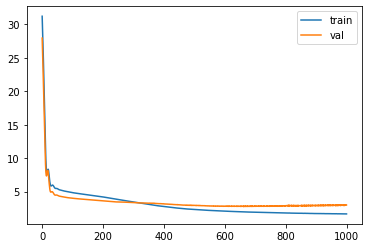

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.show()

In [14]:
with torch.no_grad():
  y_pred = model(X_test.to(device))
  test_loss = criterion(y_pred.squeeze(), y_test.to(device))
  print(test_loss)

tensor(3.3504)


# Review the results

In [15]:
df4 = df3.reset_index()

In [16]:
test_df = pd.DataFrame()
row = {'index': test_ids,
       'Solvent': df4.iloc[test_ids]['Solvent'].values,
       'Solute': df4.iloc[test_ids]['SoluteName'].values,
       'dG': y_test,
       'pred dG': y_pred[:, 0],
       'delta': abs(y_test - y_pred[:, 0])}
# print(row)
test_results = pd.DataFrame.from_dict(row)

In [16]:
for solvent in df